### Project Topic: Customer Segmentation Using K-Means on Purchase Data	
#### Objective: Group customers into segments based on their purchase behavior.	
#### Process:	
- EDA
- Step 1:	Use a dataset with customer transactions and aggregate features like total spend, frequency, and recency.
- Step 2:	Normalize the data and apply the K-Means algorithm to create customer segments.
- Step 3:	Analyze the characteristics of each segment (e.g., high-value customers, infrequent buyers).
#### Evaluation:	
- Use silhouette scores to assess clustering performance.
- Visualize segments using scatter plots or bar charts.
- Compare segments with business-defined categories (if available).

#### About the dataset:

The file scanner_data.csv contains he data provide detailed information about quantities, characteristics and values of goods sold as well as their prices.

The data is organized into 8 columns, each representing key attributes of retail store transactions. This dataset can be used contains enough information to perform RFM then segment customers.


In [0]:
path ="/FileStore/tables/scanner_data.csv"
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(5)



+---+----------+-----------+--------------+------------+-----+--------+------------+
|_c0|      Date|Customer_ID|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|
+---+----------+-----------+--------------+------------+-----+--------+------------+
|  1|2016-01-02|       2547|             1|         X52|0EM7L|     1.0|        3.13|
|  2|2016-01-02|        822|             2|         2ML|68BRQ|     1.0|        5.46|
|  3|2016-01-02|       3686|             3|         0H2|CZUZX|     1.0|        6.35|
|  4|2016-01-02|       3719|             4|         0H2|549KK|     1.0|        5.59|
|  5|2016-01-02|       9200|             5|         0H2|K8EHH|     1.0|        6.88|
+---+----------+-----------+--------------+------------+-----+--------+------------+
only showing top 5 rows



#### A. Data Preparation


In [0]:
#Schema checking
df.printSchema()

# Checking Values
print(f"Number of counts: {df.count()}")
print(f"Number of columns: {len(df.columns)}")


root
 |-- _c0: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Customer_ID: integer (nullable = true)
 |-- Transaction_ID: integer (nullable = true)
 |-- SKU_Category: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Sales_Amount: double (nullable = true)

Number of counts: 131706
Number of columns: 8


In [0]:
#check for missing data
from pyspark.sql.functions import col, sum
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+----+-----------+--------------+------------+---+--------+------------+
|_c0|Date|Customer_ID|Transaction_ID|SKU_Category|SKU|Quantity|Sales_Amount|
+---+----+-----------+--------------+------------+---+--------+------------+
|  0|   0|          0|             0|           0|  0|       0|           0|
+---+----+-----------+--------------+------------+---+--------+------------+



In [0]:
# check for duplicate
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Numbers of duplicate value: {duplicate_count}")

Numbers of duplicate value: 0


In [0]:
#dropping unessecary variable
df = df.drop("_c0")
df.show(5)

+----------+-----------+--------------+------------+-----+--------+------------+
|      Date|Customer_ID|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|
+----------+-----------+--------------+------------+-----+--------+------------+
|2016-01-02|       2547|             1|         X52|0EM7L|     1.0|        3.13|
|2016-01-02|        822|             2|         2ML|68BRQ|     1.0|        5.46|
|2016-01-02|       3686|             3|         0H2|CZUZX|     1.0|        6.35|
|2016-01-02|       3719|             4|         0H2|549KK|     1.0|        5.59|
|2016-01-02|       9200|             5|         0H2|K8EHH|     1.0|        6.88|
+----------+-----------+--------------+------------+-----+--------+------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import col

# Chuyển đổi Customer_ID và Transaction_ID sang dạng string
df = df.withColumn("Customer_ID", col("Customer_ID").cast("string"))
df = df.withColumn("Transaction_ID", col("Transaction_ID").cast("string"))

# Kiểm tra schema sau khi chuyển đổi
df.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Transaction_ID: string (nullable = true)
 |-- SKU_Category: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Sales_Amount: double (nullable = true)



In [0]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, count, max, datediff, current_date, sum as spark_sum


df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

#### B. Exploratory Data Analysis (EDA)


In [0]:
numeric_cols = ['Quantity', 'Sales_Amount']
# Descriptive statistics
df.describe(numeric_cols).show()


+-------+------------------+------------------+
|summary|          Quantity|      Sales_Amount|
+-------+------------------+------------------+
|  count|            131706|            131706|
|   mean|1.4853114436699932|11.981524152278366|
| stddev|3.8726674357653827|19.359699494203028|
|    min|              0.01|              0.02|
|    max|             400.0|            707.73|
+-------+------------------+------------------+



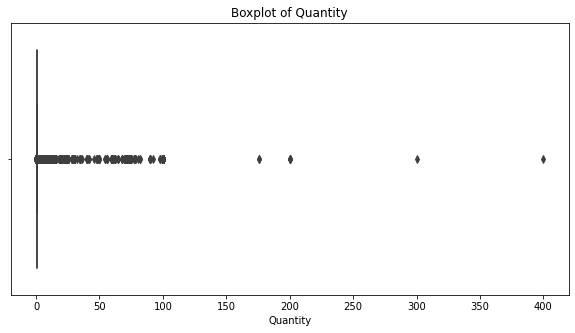

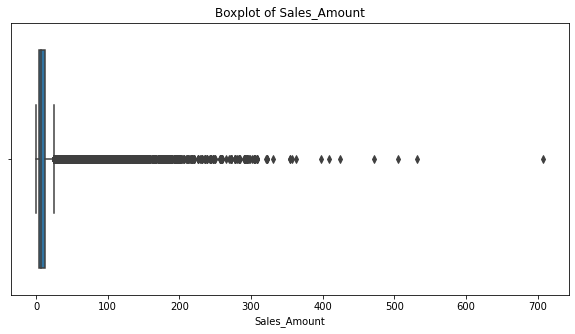

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển đổi dữ liệu sang Pandas để vẽ Boxplot
pandas_df = df.select(numeric_cols).toPandas()

# Vẽ Boxplot để kiểm tra outliers
for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=pandas_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [0]:

from pyspark.sql.functions import col

# Lọc dữ liệu theo ngưỡng cố định
df = df.filter((col("Quantity") <= 50) & (col("Sales_Amount") <= 100))

# Hiển thị dữ liệu đã lọc
df.show(5)



+----------+-----------+--------------+------------+-----+--------+------------+
|      Date|Customer_ID|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|
+----------+-----------+--------------+------------+-----+--------+------------+
|2016-01-02|       2547|             1|         X52|0EM7L|     1.0|        3.13|
|2016-01-02|        822|             2|         2ML|68BRQ|     1.0|        5.46|
|2016-01-02|       3686|             3|         0H2|CZUZX|     1.0|        6.35|
|2016-01-02|       3719|             4|         0H2|549KK|     1.0|        5.59|
|2016-01-02|       9200|             5|         0H2|K8EHH|     1.0|        6.88|
+----------+-----------+--------------+------------+-----+--------+------------+
only showing top 5 rows



In [0]:
print(f"Number of counts: {df.count()}")

Number of counts: 130367


#####Creating RFM Variables
The RFM method is a manual but very effective approach to classifying customers according to their purchasing behavior. 

- Recency (R): Time since last purchase by days.
Calculated by: current_date - max_purchase_date
- Frequency (F): Number of customer transactions in a given period of time. 
Calculated by: count Purchase_date of each customerID
- Monetary (M): Total amount of money customers spent during that period. 
Calculated by: sum Final_price of each customerID


In [0]:
from pyspark.sql.functions import col, datediff, lit

# Import hàm max từ Spark với tên khác để tránh xung đột
from pyspark.sql.functions import max as spark_max

# 1. Tìm ngày cuối cùng trong dataset
max_date = df.select(spark_max("Date")).collect()[0][0]

# 2. Nhóm dữ liệu theo Customer_ID và lấy ngày mua hàng cuối cùng
last_purchase = df.groupBy("Customer_ID").agg(spark_max("Date").alias("Last_Purchase_Date"))

# 3. Tính Recency (khoảng cách giữa ngày cuối cùng và ngày mua hàng cuối cùng)
last_purchase = last_purchase.withColumn("Recency", datediff(lit(max_date), col("Last_Purchase_Date")))

# Join Recency vào DataFrame chính
df = df.join(last_purchase.select("Customer_ID", "Recency"), on="Customer_ID", how="left")

# Hiển thị kết quả
df.show(5)



+-----------+----------+--------------+------------+-----+--------+------------+-------+
|Customer_ID|      Date|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|Recency|
+-----------+----------+--------------+------------+-----+--------+------------+-------+
|       2547|2016-01-02|             1|         X52|0EM7L|     1.0|        3.13|    259|
|        822|2016-01-02|             2|         2ML|68BRQ|     1.0|        5.46|    332|
|       3686|2016-01-02|             3|         0H2|CZUZX|     1.0|        6.35|    298|
|       3719|2016-01-02|             4|         0H2|549KK|     1.0|        5.59|    301|
|       9200|2016-01-02|             5|         0H2|K8EHH|     1.0|        6.88|    266|
+-----------+----------+--------------+------------+-----+--------+------------+-------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import countDistinct

frequency = df.groupBy("Customer_ID").agg(countDistinct("Date").alias("Frequency"))

# Join với DataFrame ban đầu
df = df.join(frequency, on="Customer_ID", how="left")


In [0]:
#Create new columns
from pyspark.sql.functions import sum as spark_sum

monetary = df.groupBy("Customer_ID").agg(
    spark_sum("Sales_Amount").alias("Monetary")
)

# Join the df
df = df.join(monetary, on="Customer_ID", how="left")


df.show(5)

+-----------+----------+--------------+------------+-----+--------+------------+-------+---------+------------------+
|Customer_ID|      Date|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|Recency|Frequency|          Monetary|
+-----------+----------+--------------+------------+-----+--------+------------+-------+---------+------------------+
|       2547|2016-01-02|             1|         X52|0EM7L|     1.0|        3.13|    259|        7|121.36000000000001|
|        822|2016-01-02|             2|         2ML|68BRQ|     1.0|        5.46|    332|        3|              20.4|
|       3686|2016-01-02|             3|         0H2|CZUZX|     1.0|        6.35|    298|       15| 405.4400000000001|
|       3719|2016-01-02|             4|         0H2|549KK|     1.0|        5.59|    301|       10|420.71999999999997|
|       9200|2016-01-02|             5|         0H2|K8EHH|     1.0|        6.88|    266|        2|             18.01|
+-----------+----------+--------------+------------+----

In [0]:
display(df)

Customer_ID,Date,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Recency,Frequency,Monetary
2547,2016-01-02,1,X52,0EM7L,1.0,3.13,259,7,121.36000000000001
822,2016-01-02,2,2ML,68BRQ,1.0,5.46,332,3,20.4
3686,2016-01-02,3,0H2,CZUZX,1.0,6.35,298,15,405.4400000000001
3719,2016-01-02,4,0H2,549KK,1.0,5.59,301,10,420.71999999999997
9200,2016-01-02,5,0H2,K8EHH,1.0,6.88,266,2,18.01
5010,2016-01-02,6,JPI,GVBRC,1.0,10.77,364,1,10.77
1666,2016-01-02,7,XG4,AHAE7,1.0,3.65,0,52,679.19
1666,2016-01-02,7,FEW,AHZNS,1.0,8.21,0,52,679.19
1253,2016-01-02,8,0H2,9STQJ,1.0,8.25,320,5,161.51000000000008
5541,2016-01-02,9,N5F,7IE9S,1.0,8.18,282,11,392.53000000000003


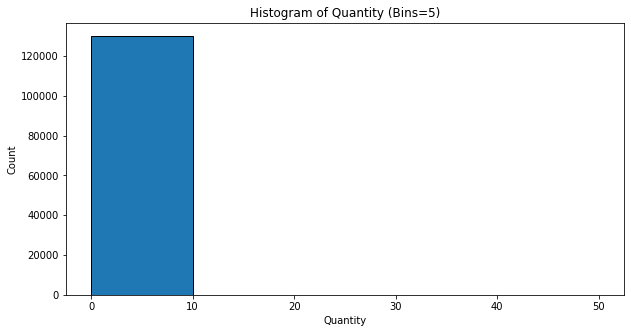

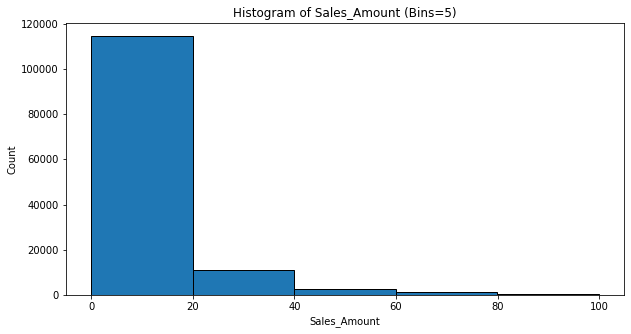

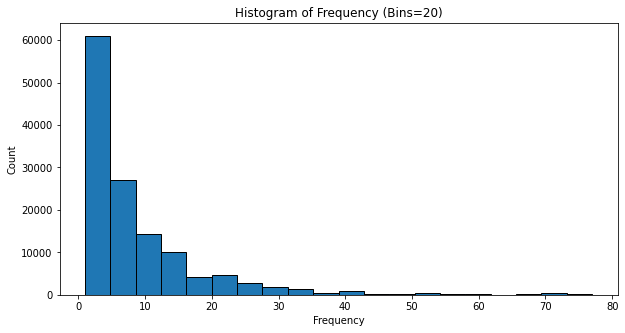

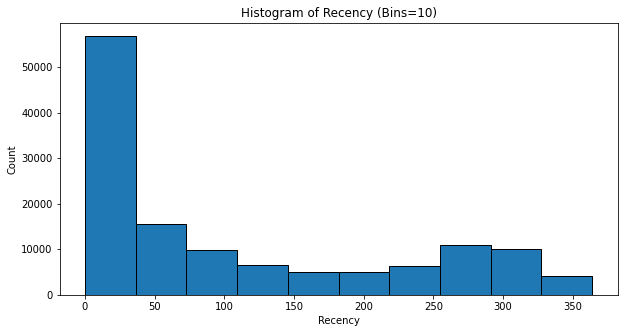

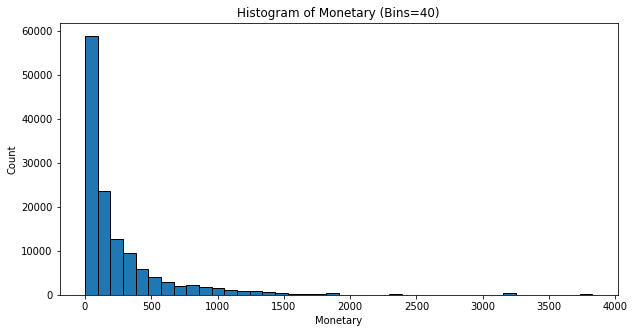

In [0]:
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['Quantity', 'Sales_Amount', 'Frequency', "Recency", 'Monetary']
pandas_df = df.select(numeric_cols).toPandas()


bins_dict = {
    "Quantity": 5,
    "Sales_Amount": 5,
    "Frequency": 20,
    "Recency": 10,
    "Monetary": 40
}

for col in pandas_df:
    plt.figure(figsize=(10, 5))
    plt.hist(pandas_df[col], bins=bins_dict[col], edgecolor='black')
    plt.title(f"Histogram of {col} (Bins={bins_dict[col]})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


#### Observation
- Histogram The RFM as well as Quantity and Sales_Amount tend to be right-skwed similarly. This shows that:
- Customers usually buy in quantities under 75 -> most of them are retail customers, this may be the main focus audience
- Sales_Amount shows that each order is mostly under $150, this number may be an indicator set to encourage consumers to spend up to that limit to receive promotions
- Recency shows that the time customers return to buy within less than 50 days is quite high -> Our **Active customers** However, there is also a relatively large number of **Inactive customers** with the most recent purchase time more than 300 days ago.
- Frequency is also a useful indicator to help classify customers as **One-time Buyers or Loyal Buyers**
- Customers spend the most on products under $500, ranging from $2000 to $4000

### C. Applying and Evaluate K-Means Clustering 
Explaination:

K-Means is an unsupervised clustering algorithm that divides data into 𝑘 clusters based on the distances between data points.

This algorithm assigns each data point to the cluster with the closest center, based on Euclidean distance (or other distance measures).


#### Normalize data with StandardScaler:

K-means requires the input features to be provided as a single vector.
VectorAssembler helps to combine the feature columns (Total_Spend, Frequency, Recency) into a vector to be input to the algorithm. Then putting in into StandardScaler step.


In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Create vector for features needed to Scale (removing IDs, category and date features because they do not have numerical values)
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features")
df = assembler.transform(df)


# Apply StandardScaler
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)#with Std and Mean help standard data not being skewed and more balanced between big and small values

#Check result
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


df.select("Customer_ID", "scaled_features").show(5, truncate=False)

+-----------+------------------------------------------+
|Customer_ID|scaled_features                           |
+-----------+------------------------------------------+
|2547       |[-0.2581403603227735,-0.6384802455806213] |
|822        |[-0.2581403603227735,-0.44006951375896636]|
|3686       |[-0.2581403603227735,-0.3642817234923256] |
|3719       |[-0.2581403603227735,-0.4289993870908054] |
|9200       |[-0.2581403603227735,-0.31914966861443844]|
+-----------+------------------------------------------+
only showing top 5 rows



#### Method 01: Apply K-means Clustering to the whole dataset

**Silhouette** is a method of interpretation and validation of consistency within clusters of data. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a higher Silhouette Coefficient score relates to a model with better defined clusters

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np


# Testing k from 2 to 10 Since the entire dataset has many features, more clusters need to be tested for analysis.
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Sử dụng ClusteringEvaluator để tính Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Vòng lặp thử các giá trị k
for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    model = kmeans.fit(df)
    
    centroids = np.array(model.clusterCenters())

    # Dự đoán cụm
    clustered_df = model.transform(df)
    
    # Tính Silhouette Score
    silhouette = evaluator.evaluate(clustered_df)
    print(f"k = {k}, Silhouette Score = {silhouette}")

k = 2, Silhouette Score = 0.2979337297888323
k = 3, Silhouette Score = 0.4546685684975188
k = 4, Silhouette Score = 0.49453839045124653
k = 5, Silhouette Score = 0.559461403793304
k = 6, Silhouette Score = 0.5489416963990412
k = 7, Silhouette Score = 0.46734335653150333
k = 8, Silhouette Score = 0.5360757328007041
k = 9, Silhouette Score = 0.5404491552707867
k = 10, Silhouette Score = 0.4881371261899931


The highest Silhouette Score = 0.55 with k = 5, for further analyzed, I'm using the Elbow Method

**Elbow Method**

Using Elbow Method to evaluate K-means clustering then choosing the optimal k value.

As we increase k, the WCSS typically decreases because we’re creating more clusters, which tend to capture more data variations. However, there comes a point where adding more clusters results in only a marginal decrease in WCSS. This is where we observe an “elbow” shape in the graph.

We calculate a distance measure called WCSS (Within-Cluster Sum of Squares). This tells us how spread out the data points are within each cluster.



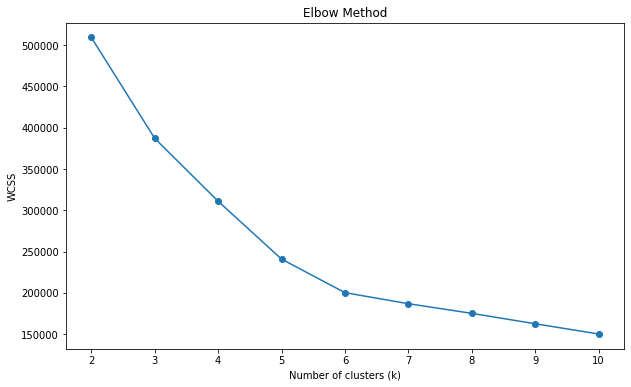

In [0]:
wcss = []

# Vòng lặp qua các giá trị k
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    kmeans_model = kmeans.fit(df)
    wcss.append(kmeans_model.summary.trainingCost)

# Vẽ đồ thị Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


At Elbow Point: The number of clusters is sufficient to separate the data into tight and meaningful groups. The Elbow point is here with k = 5, as well as with its highest Silhoutte **index**

In [0]:

from sklearn.metrics import calinski_harabasz_score
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
# Áp dụng KMeans với k = 6
kmeans = KMeans(featuresCol="scaled_features", k=5, seed=1)
model = kmeans.fit(df)

# Gán nhãn cụm cho dữ liệu
clustered_df = model.transform(df)

def vector_to_array(vector):
    return vector.toArray().tolist()

vector_to_array_udf = udf(vector_to_array, ArrayType(FloatType()))
clustered_df = clustered_df.withColumn("scaled_features_array", vector_to_array_udf(clustered_df["scaled_features"]))

# Chuyển đổi dữ liệu sang Pandas
pandas_df = clustered_df.select("scaled_features_array", "prediction").toPandas()

# Tính Calinski-Harabasz Index
ch_score = calinski_harabasz_score(pandas_df["scaled_features_array"].tolist(), pandas_df["prediction"])
print(f"Calinski-Harabasz Index (k=5): {ch_score:.2f}")




Calinski-Harabasz Index (k=5): 55708.64


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
def vector_to_array(vector):
    return vector.toArray().tolist()

#### Test 02: Apply K-means Clustering to only the RFM mectrics

In [0]:
from pyspark.ml.feature import VectorAssembler

# Chọn các biến RFM
rfm_assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="rfm_features"
)
rfm_df = rfm_assembler.transform(df)


In [0]:

# Chọn các biến RFM
rfm_assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="rfm_features"
)
rfm_df = rfm_assembler.transform(df)

# Kiểm tra nếu cột 'scaled_rfm_features' đã tồn tại
if "scaled_rfm_features" in rfm_df.columns:
    rfm_df = rfm_df.drop("scaled_rfm_features")

# Áp dụng StandardScaler
rfm_scaler = StandardScaler(
    inputCol="rfm_features",
    outputCol="scaled_rfm_features",
    withStd=True,
    withMean=True
)
rfm_model_scaler = rfm_scaler.fit(rfm_df)
rfm_df = rfm_model_scaler.transform(rfm_df)

# Hiển thị kết quả
rfm_df.select("Customer_ID", "rfm_features", "scaled_rfm_features").show(5, truncate=False)


+-----------+-------------------------------+--------------------------------------------------------------+
|Customer_ID|rfm_features                   |scaled_rfm_features                                           |
+-----------+-------------------------------+--------------------------------------------------------------+
|2547       |[259.0,7.0,121.36000000000001] |[1.3314056789970579,-0.14898849696901123,-0.35100573715147465]|
|822        |[332.0,3.0,20.4]               |[1.9776828024724824,-0.5390259658431052,-0.6209074798041817]  |
|3686       |[298.0,15.0,405.4400000000001] |[1.6766770189359834,0.631086440779177,0.4084404499798748]     |
|3719       |[301.0,10.0,420.71999999999997]|[1.7032363527774392,0.14353960468655932,0.4492892874178039]   |
|9200       |[266.0,2.0,18.01]              |[1.3933774579604548,-0.6365353330616288,-0.6272967940369469]  |
+-----------+-------------------------------+--------------------------------------------------------------+
only showing top 5 

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np


# Các giá trị k cần thử
k_values_rfm = [2, 3, 4, 5, 6]

# Sử dụng ClusteringEvaluator để tính Silhouette Score
evaluator_rfm = ClusteringEvaluator(featuresCol="scaled_rfm_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Vòng lặp thử các giá trị k
for k in k_values_rfm:
    kmeans_rfm = KMeans(featuresCol="scaled_rfm_features", k=k, seed=1)
    model_rfm = kmeans_rfm.fit(rfm_df)
    
    centroids_rfm = np.array(model_rfm.clusterCenters())

    # Dự đoán cụm
    clustered_rfm_df = model_rfm.transform(rfm_df)
    
    # Tính Silhouette Score
    silhouette_rfm = evaluator_rfm.evaluate(clustered_rfm_df)
    print(f"k = {k}, Silhouette Score = {silhouette_rfm}")

k = 2, Silhouette Score = 0.4494242411913734
k = 3, Silhouette Score = 0.6834480795200039
k = 4, Silhouette Score = 0.6946088890677381
k = 5, Silhouette Score = 0.5606797009287721
k = 6, Silhouette Score = 0.5769043077302741


With k clustering from 2-6, k=4 has the highest Silhoutte index (0.69), indicating that the best way to classify customers into 5 groups is to classify them.

**The Silhouttee index is higher than applying K-means to the whole dataset.**

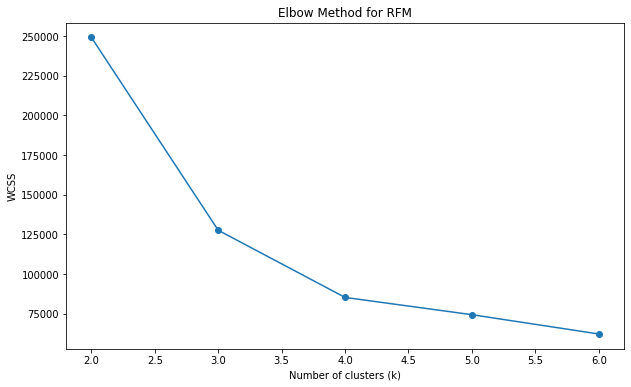

In [0]:
import matplotlib.pyplot as plt

wcss_rfm = []

# Vòng lặp qua các giá trị k
for k in range(2, 7):
    kmeans_rfm = KMeans(featuresCol="scaled_rfm_features", k=k, seed=1)
    model_rfm = kmeans_rfm.fit(rfm_df)
    wcss_rfm.append(model_rfm.summary.trainingCost)

# Vẽ đồ thị Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(2, 7), wcss_rfm, marker='o')
plt.title('Elbow Method for RFM')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

The Elbow point is here with k = 4, as well as with its highest Silhoutte **index**

In [0]:

from sklearn.metrics import calinski_harabasz_score

# Áp dụng KMeans với k = 4
kmeans_rfm = KMeans(featuresCol="scaled_rfm_features", k=4, seed=1)
model_rfm = kmeans_rfm.fit(rfm_df)

# Gán nhãn cụm cho dữ liệu
clustered_rfm_df = model_rfm.transform(rfm_df)

vector_to_array_udf = udf(vector_to_array, ArrayType(FloatType()))

# Áp dụng UDF
clustered_rfm_df = clustered_rfm_df.withColumn("scaled_rfm_array", vector_to_array_udf(clustered_rfm_df["scaled_rfm_features"]))

# Chuyển đổi sang Pandas
pandas_rfm_df = clustered_rfm_df.select("scaled_rfm_array", "prediction").toPandas()

# Tính Calinski-Harabasz Index
ch_score_rfm = calinski_harabasz_score(pandas_rfm_df["scaled_rfm_array"].tolist(), pandas_rfm_df["prediction"])
print(f"Calinski-Harabasz Index for RFM metrics (k=4): {ch_score_rfm:.2f}")

Calinski-Harabasz Index for RFM metrics (k=4): 155881.56


The value of k that yields the maximum CH index is chosen as the optimal number of clusters.


### D. Two methods Evaluation


In [0]:
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder.appName("ComparisonTable").getOrCreate()

# Dữ liệu
data = [
    ("K-Means on the whole dataset", 0.559, 55708.64, 5),
    ("K-Means on RFM metrics", 0.690, 155881.56, 4)
]

# Tạo DataFrame
comparison_df = spark.createDataFrame(data, ["Method", "Silhouette Score", "CH Score", "Number of K Clusters"])

# Hiển thị
display(comparison_df)


Method,Silhouette Score,CH Score,Number of K Clusters
K-Means on the whole dataset,0.559,55708.64,5
K-Means on RFM metrics,0.69,155881.56,4


Applying K-means to the entire dataset gives not better results with lower Sillouette and CH-Score than Method 2 - applying K-means to RFM index.

It is possible that the remaining variables (Date, Transaction_ID, SKU_Category, SKU,..) cause noise in the model and do not really help distinguish customer groups clearly.

As for RFM variables (Recency, Frequency, Monetary), they are the main characteristic variables for customer segmentation analysis, helping the model easily identify different customer groups.

### E. Plot

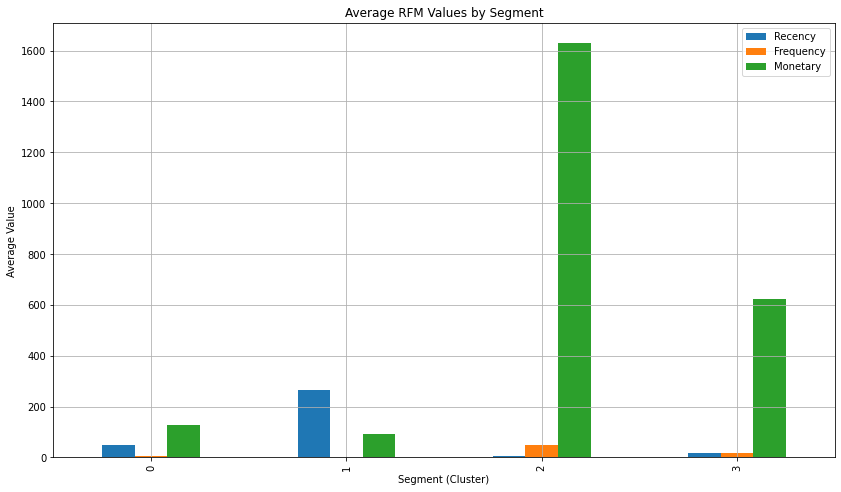

In [0]:

# Chuyển DataFrame PySpark sang Pandas để trực quan hóa
summary_pandas = summary_df.toPandas()
summary_pandas.sort_values(by="prediction", inplace=True)

# Vẽ bar chart
summary_pandas.plot(
    kind="bar",
    x="prediction",
    y=["Avg_Recency", "Avg_Frequency", "Avg_Monetary"],
    figsize=(14, 8),
    title="Average RFM Values by Segment"
)


plt.xlabel("Segment (Cluster)")
plt.ylabel("Average Value")
plt.legend(["Recency", "Frequency", "Monetary"])
plt.grid(True)
plt.show()


In [0]:
# Tính trung bình của các biến RFM theo từng cụm
summary_df = clustered_rfm_df.groupBy("prediction").agg(
    {"Recency": "avg", "Frequency": "avg", "Monetary": "avg"}
)

# Đổi tên cột cho dễ đọc
summary_df = summary_df.withColumnRenamed("avg(Recency)", "Avg_Recency") \
                       .withColumnRenamed("avg(Frequency)", "Avg_Frequency") \
                       .withColumnRenamed("avg(Monetary)", "Avg_Monetary")

# Hiển thị bảng kết quả
summary_df.show()


+----------+------------------+------------------+------------------+
|prediction|       Avg_Recency|      Avg_Monetary|     Avg_Frequency|
+----------+------------------+------------------+------------------+
|         1|265.24523815483195|  93.8565852376535| 3.245513478337046|
|         3|18.507940552016986| 622.5951108280218|18.846114649681528|
|         2| 6.427072927072927| 1628.524483016966| 48.84415584415584|
|         0| 49.32266942411709|127.35725246579847|  5.45173401209036|
+----------+------------------+------------------+------------------+



### Customer Segment Analysis:

##### Cluster 0: Potential Loyalists 
- Avg_Recency = 49.32: These customers have made a recent purchase (within the last 50 days).
- Avg_Monetary = 127.36: Their total spending is average.
- Avg_Frequency = 5.45: They have made a few purchases, indicating some interest in the brand.

This group includes customers who are new or in the discovery phase of the brand. They have the potential to become loyal customers, but are currently in the trial shopping phase.
 

##### Cluster 1: Lost Customers
- Avg_Recency = 265.25: These customers have not made a purchase in a long time (average of more than 8 months).
- Avg_Monetary = 93.86: Their total spending is low.

- Avg_Frequency = 3.25: They buy very few times.

This is a group of customers who are infrequent or at risk of leaving the brand. They may be customers who have purchased in the past but are no longer coming back to shop.


##### Cluster 2: Loyal customers
- Recency: Low (they have recently purchased).

- Frequency: Medium.

- Monetary: Medium.

This is a group of customers who are loyal and most valuable to the business. They come back to shop frequently and spend a lot.


#####Cluster 3: Champions

- Avg_Recency = 18.51: They have recently purchased.

- Avg_Monetary = 622.60: Their total spending is high.

- Avg_Frequency = 18.84: They shop quite frequently.

This is a group of customers who spend quite a lot and come back to shop frequently. However, they have not reached the highest level of loyalty.

References:
- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
- https://en.wikipedia.org/wiki/Silhouette_(clustering)
- https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index#Finding_the_optimal_number_of_clusters